<a href="https://colab.research.google.com/github/ojasnadkar96/cs273p_project/blob/master/logReg2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logistic Regression (PCA)**

Importing all the required libraries.

In [0]:
#Importing libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

The two functions below are to save and import pickle files.<br>

In [0]:
def save_pkl(df,name):
    fullname = name+'.pkl'
    output = open(fullname, 'wb')
    pickle.dump(df, output)
    output.close()

In [0]:
def import_pkl(df,name):
    fullname = name+'.pkl'
    df = pickle.load(open(fullname, 'rb'))
    return df

In [0]:
df_train = pd.DataFrame()
df_valid = pd.DataFrame()
df_test = pd.DataFrame()
df_train_l = pd.DataFrame()
df_valid_l = pd.DataFrame()
df_test_l = pd.DataFrame()

In [0]:
df_train = import_pkl(df_train,'train_x')
df_valid = import_pkl(df_valid,'valid_x')
df_test = import_pkl(df_test,'test_x')
df_train_l = import_pkl(df_train_l,'train_x_l')
df_valid_l = import_pkl(df_valid_l,'valid_x_l')
df_test_l = import_pkl(df_test_l,'test_x_l')

In [0]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)
print(df_train_l.shape)
print(df_valid_l.shape)
print(df_test_l.shape)

(77854, 168)
(13737, 168)
(10175, 168)
(77854, 1)
(13737, 1)
(10175, 1)


Pre-processed data with a total of 168 features has been imported into dataframes.<br>
We will apply PCA on these datasets to reduce the dimensionality of this data.<br>

In [0]:
from sklearn.decomposition import PCA
dims = []
variances = []
optimum_dim = 168
threshold=0.01
for dim in range(1, 168):
    pca = PCA(n_components=dim)
    pca.fit(df_train)
    variance = np.array(pca.explained_variance_ratio_)
    variance = variance.min()
    if threshold < variance:
        optimum_dim = dim
        dims.append(dim)
        variances.append(variance)
    else:
        break

24


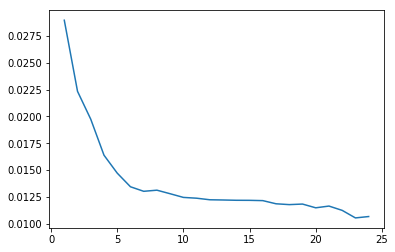

In [0]:
print(optimum_dim)
import matplotlib.pyplot as plt
plt.plot(dims, variances)
plt.show()

Optimal value for PCA is 24 features, as we can see in the graph above.

In [0]:
pca = PCA(n_components=24)
pca_train = pca.fit_transform(df_train)
print(pca.explained_variance_ratio_)

[0.02895832 0.02233306 0.01973748 0.01650445 0.01475587 0.01344415
 0.01335572 0.01309565 0.01292917 0.0124977  0.01237302 0.01219332
 0.01212638 0.01212346 0.01208168 0.01203546 0.01201326 0.01197506
 0.01182699 0.01175752 0.0116977  0.01141904 0.01078819 0.01051257]


We have now reduced the train dataset into 24 features using PCA.

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score

In [0]:
#Logistic Regression Model Training
from sklearn.linear_model import LogisticRegression
LogReg1 = LogisticRegression(class_weight='balanced')
LogReg1.fit(pca_train,np.ravel(df_train_l))

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#Logistic Regression Training Score
score = LogReg1.score(pca_train,np.ravel(df_train_l))
print('Training error: ', score*100)

Training error:  53.35499781642562


The accuracy for training data after PCA for Logistic Regression is around 53.35%

In [0]:
#Logistic Regression Validation Score
pca_valid = pca.transform(df_valid)
score = LogReg1.score(pca_valid,np.ravel(df_valid_l))
print('Validation error: ', score*100)

Validation error:  53.21394773240154


In order to increase the accuracy, we now head towards hyperparameter tuning.

In [0]:
from pprint import pprint
pprint(LogReg1.get_params())

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [0]:
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = [1, 10, 100]
max_iter = [10, 20]
tol = [0.01, 0.001]

# Create the random grid
random_grid = {'penalty': penalty,
               'max_iter': max_iter,
               'C': C,
               'tol': tol}
pprint(random_grid)

{'C': [1, 10, 100],
 'max_iter': [10, 20],
 'penalty': ['l1', 'l2'],
 'tol': [0.01, 0.001]}


For randomized SearchCV, we first pass random values as hyperparameters and then observe the results.

In [0]:
from sklearn.model_selection import PredefinedSplit
train_len = len(pca_train)
valid_len = len(pca_valid)
pca_tv = np.concatenate((pca_train,pca_valid), axis=0)
df_tv_l = pd.concat([df_train_l, df_valid_l], ignore_index = True)
bound = np.array([(i < train_len) * -1 for i in range(train_len + valid_len)])
split = PredefinedSplit(bound)

In [0]:
LogReg2 = LogisticRegression()
logreg_random = RandomizedSearchCV(estimator = LogReg2, param_distributions = random_grid, n_iter = 100, n_jobs = -1, verbose = 1, cv = split)

logreg_random.fit(pca_tv,np.ravel(df_tv_l))

logreg_random.best_params_

Fitting 1 folds for each of 24 candidates, totalling 24 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   49.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 1, 'max_iter': 10, 'penalty': 'l1', 'tol': 0.001}

Out of all the random values, above values have given us the maximum score. Now we train the model on these parameters and check for the accuracy score.

In [0]:
LogReg3 = LogisticRegression(class_weight='balanced',
 C=1,
 max_iter=10,
 penalty='l1',
 tol=0.001)
LogReg3.fit(pca_train,np.ravel(df_train_l))
score = LogReg3.score(pca_train,np.ravel(df_train_l))
print('Train Score: ', score*100)

Train Score:  53.34215326123256


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
score = LogReg3.score(pca_valid,np.ravel(df_valid_l))
print('Valid Score: ', score*100)

Valid Score:  53.1921089029628


Now, we use GridSearchCV to tune the hyperparameters in range of the above obtained best parameters in RandomizedSearchCV.

In [0]:
from sklearn.model_selection import GridSearchCV

max_iter = [10,20]
C = [1]
penalty = ['l1','l2']
tol = [0.01, 0.001]

search_grid = {'max_iter' : max_iter,
               'C': C,
               'penalty': penalty,
               'tol': tol}

pprint(search_grid)

{'C': [1], 'max_iter': [10, 20], 'penalty': ['l1', 'l2'], 'tol': [0.01, 0.001]}


In [0]:
LogReg4 = LogisticRegression()
logreg_grid = GridSearchCV(estimator = LogReg4, param_grid = search_grid, n_jobs = 2, verbose = 1, cv = split)

logreg_grid.fit(pca_tv, np.ravel(df_tv_l))

logreg_grid.best_params_

Fitting 1 folds for each of 8 candidates, totalling 8 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   8 out of   8 | elapsed:   15.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 1, 'max_iter': 10, 'penalty': 'l1', 'tol': 0.001}

Now, after hyperparameter tuning is done, we find the final training, validation and test error.

In [0]:
LogReg_final = LogisticRegression(C=1, max_iter=10, penalty='l1', tol=0.001)
LogReg_final.fit(pca_train, np.ravel(df_train_l))
train_score = LogReg_final.score(pca_train, np.ravel(df_train_l))
print('Final Train score: ', train_score*100)

Final Train score:  54.74477868831402


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
valid_score = LogReg_final.score(pca_valid, np.ravel(df_valid_l))
print('Final Validation score: ', valid_score*100)

Final Validation score:  54.487879449661506


In [0]:
pca_test = pca.transform(df_test)
test_score = LogReg_final.score(pca_test, np.ravel(df_test_l))
print('Final Train score: ', test_score*100)

Final Train score:  55.06633906633907


In [0]:
from sklearn import metrics
conf = metrics.confusion_matrix(df_test_l,LogReg_final.predict(pca_test))
TP = conf[1, 1]
TN = conf[0, 0]
FP = conf[0, 1]
FN = conf[1, 0]
print(conf)

[[5124  362    0]
 [3075  479    0]
 [ 950  185    0]]


In [0]:
print(TN*100 / float(TN + FP))

93.4013853445133


In [0]:
print(FP*100 / float(TN + FP))

6.598614655486694


In [0]:
print(TP*100 / float(TP + FP))

56.95600475624257


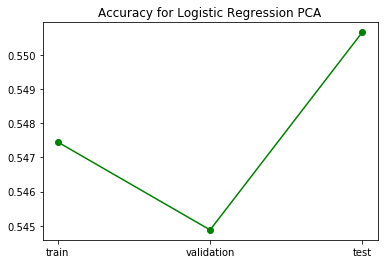

In [0]:
scores = [train_score, valid_score, test_score]
labels = ['train','validation','test']
plt.title("Accuracy for Logistic Regression PCA")
plt.plot(labels, scores, marker='o', color = "g", label = "Final model scores")
plt.show()